# Question 2

Here we attempt to calculate the bias and variance of various models which use linear regression with polynomial features of higher order terms over 20 different training datasets. The data has luckily been split into test and training set already.

## Getting the Dataset

The initial version of this project was run on google colab. Hence, there was some effort put into mounting the google  drive folder as a filesystem, and then subsequently navigating the file system. The following code just displays a tree of the current folder and proceeds to load the dataset for question 1.

In [1]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

list_files('./')

home = '.'

In [2]:
import pickle
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

fname = "./Q2_data/X_train.pkl"
outfile = open(fname,'rb')
X_train = np.array(pickle.load(outfile))
outfile.close()

fname = "./Q2_data/Y_train.pkl"
outfile = open(fname,'rb')
Y_train = np.array(pickle.load(outfile))
outfile.close()

fname = "./Q2_data/X_test.pkl"
outfile = open(fname,'rb')
X_test = np.array(pickle.load(outfile))
outfile.close()

fname = "./Q2_data/Fx_test.pkl"
outfile = open(fname,'rb')
Y_test = np.array(pickle.load(outfile))
outfile.close()

The above code segment uses pickle to load the dataset.

Luckily, the dataset has already been split into testing and training data already. 

## Understanding The Dataset

Before we proceed to calculate bias and variance, it might be useful to understand the underlying dataset. This will give an understanding of what degree polynomials are likely to be an underfit or an overfit for the dataset. 

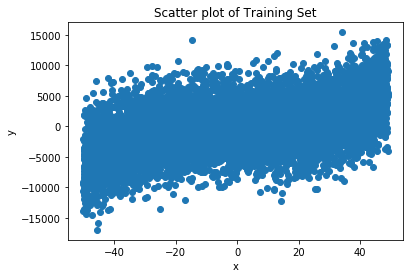

In [3]:
plt.scatter(X_train, Y_train)

plt.title('Scatter plot of Training Set')

plt.xlabel('x')
plt.ylabel('y')

plt.show()

Based on this graph, we can make confident guesses about the accuracy of certain models. Since the question asks us to use polynomials of the form:

![image.png](formula.png)

and so on until polynomial of degree nine.

As we train the models for various degrees of polynomials, we will also plot the graph to see how our hypothesis function fits on the existing dataset.

## Creating a Hypothesis Function

As part of our bias variance calculating, we require a function to calculate the hypothesized value after training our data for input test data

In [4]:
def hypothesis(xt, intercepts, coeff):
    
    intercept = np.copy(intercepts)
    coef = np.copy(coeff)
    x = np.copy(xt)

    x = np.transpose(x)
    
    hyp = coeff.dot(x)
    hyp += intercept
    return hyp

## Variance Calculation

We calculate variance as follow:

![image.png](variance.jpg)

The below code first calculates the hypothesized value for each entry in our test point, according to 10 different models. It then calculates the expectation by taking the average followed by removing the point's corresponding hypothesized value in that model. This is then subsequently squared, summed, and divided by 10 once again to calculate expectation.

The code has been vectorized extensively as the coefficients and intercept variables are 2D arrays which contain information corresponding to each training set used to generate diff models. 

In [5]:
def variance_calc(xt, intercepts, coeff):
    intercept = np.copy([intercepts])
    coef = np.copy(coeff)
    x = np.copy([xt])
    
    intercept = np.array([intercept]).reshape(-1,1)

    hyp = hypothesis(x,intercept,coef)
    
    expec_hyp =np.sum(hyp)
    expec_hyp /= intercept.size
    expec_hyp_list = np.array([expec_hyp for i in range(intercept.size)]).reshape(-1,1)

    temp = hyp-expec_hyp_list
    temp = np.square(temp)
    variance = np.sum(temp)
    variance /= intercept.size
    
    return variance

## Bias Calculation

We calculate bias as follows:

![image.png](bias.jpg)

The below code is very similiar to the variance calculation in some aspects. One again here, we must use the expected value of hypothesis which is stored in the ```expec_hyp``` variable. The actual answer for our testing dataset has been passed as a parameter to the function. Here, we have calculated the absolute value of the bias rather than the square. Both measures are equally accurate in terms of correctness. 

In [6]:
def bias_calc(xt, intercepts, coeff, ans):
    intercept = np.copy([intercepts])
    coef = np.copy(coeff)
    x = np.copy([xt])
    
    intercept = np.array([intercept]).reshape(-1,1)
    hyp = hypothesis(x,intercept,coef)
    
    expec_hyp =np.sum(hyp)
    expec_hyp /= intercept.size
    
    bias = abs(expec_hyp - ans)
    
    return bias

## Setting up datasets and variables

This following section proceeds to actually answer the question (phew finally). Like before, this just sets up some variables to be used across the board along with the dataset.

In [7]:
X_test = np.array([X_test]).reshape(-1,1)
Y_test = np.array([Y_test]).reshape(-1,1)

mean_bias =0
mean_variance = 0
coef_list = np.array([[]])
intercept_list = np.array([])

variance_list = []
bias_list = []
table_data = []
degree_hypo_list = []

## Regressing for higher order polynomials

The following section generates bias and variance values for each degree of the polynomial in the range 1 to 9 inclusive. This includes running the regression on each of the 10 training subsets obtained in the first section. 

To generate the features, we use the inbuilt functionality of PolynomialFeatures

In [8]:
for degree in range(1,10):
    
    mean_bias =0
    mean_variance = 0
    coef_list = np.array([[]])
    intercept_list = np.array([])
    
    x_test = np.copy(X_test)
    
    hypo_degree = []
    
    for model in range(0,20):
        cur_x_train = X_train[model,:].reshape(-1,1)
        cur_y_train = Y_train[model,:].reshape(-1,1)
        
        # We combine x,y into a pair to randomly shuffle
        cur_dataset = np.append(cur_x_train, cur_y_train, axis=1)
        np.random.shuffle(cur_dataset)
        
        cur_x_train = cur_dataset[:, 0].reshape(-1,1)
        cur_y_train = cur_dataset[:, 1].reshape(-1,1)

        poly = PolynomialFeatures(degree, include_bias=False)
        cur_x_train = poly.fit_transform(cur_x_train)

        regressor = LinearRegression()  
        regressor.fit(cur_x_train, cur_y_train)

        intercept = regressor.intercept_
        intercept_list = np.append(intercept_list,float(intercept))

        coef = regressor.coef_
        coef_list = np.append(coef_list,coef[0])


    coef_list = np.resize(coef_list,(20,degree))
    poly = PolynomialFeatures(degree,include_bias=False)
    x_test = poly.fit_transform(x_test)

    
    for calc in range(int(X_test.shape[0])):
        temp = hypothesis(x_test[calc], intercept_list, coef_list)
        hypo_degree.append(temp[0])
        mean_bias += bias_calc(x_test[calc,:], intercept_list, coef_list, Y_test[calc,0]) ** 2
        mean_variance += variance_calc(x_test[calc,:], intercept_list, coef_list)

    degree_hypo_list.append(hypo_degree)
    mean_bias/= (x_test.shape[0])
    mean_variance/= (x_test.shape[0])

    bias_list.append(mean_bias)
    variance_list.append(mean_variance)
    table_data.append([degree, mean_bias, mean_variance])

## Tabulate the Data

Let us view the results of the model for various degrees of polynomials on the test set. The below table displays the average bias^2 and average variance for each corresponding degree of the polynomial.

In [9]:
from tabulate import tabulate
print(tabulate(table_data, headers=['Degree', 'Bias^2', 'Variance']))

  Degree     Bias^2    Variance
--------  ---------  ----------
       1  999228        70545.5
       2  954619       125871
       3    9389.73    150074
       4   10907.3     212236
       5    9339.19    276388
       6   10248.6     316863
       7   10335.3     357511
       8   10148.9     404291
       9   10803.1     458401


## Graphing the data

We may proceed to graph the obtained data for better insight into the training model.

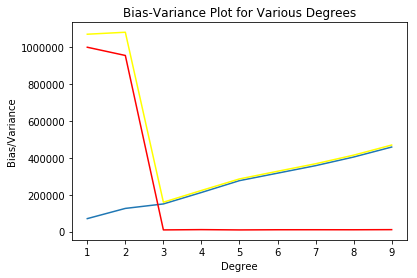

In [22]:
total_error = []
for i in range(len(variance_list)):
    total_error.append(variance_list[i] + bias_list[i])

plt.plot([i for i in range(1, 10)], variance_list)
plt.plot([i for i in range(1, 10)], bias_list, color='red')
plt.plot([i for i in range(1, 10)], total_error, color='yellow')
plt.title('Bias-Variance Plot for Various Degrees')
plt.xlabel('Degree')
plt.ylabel('Bias/Variance')
plt.show()

We can clearly see how the bias and variance change as a function of degree. When we began our regression with degree one polynomial, we can see high bias and low variance which aligns with our expectation as this is an underfit model. It is unable to model the training data accurately and as a result is consistently incorrect on the test dataset.

As we progress however, the bias drops as the model is able to more accurately model the training data, due to the polynomial features available. However, as the degree of the polynomial increases, the model seems to represent an overfit as the bias drops but variance simultaneously increases. This is most likely an indication that the test set varied from the training set and the model over-learnt the training data.

Apart from the graphical interpretation, we can see that the bias values are dropping from the table above. The values have a steeper decline initially followed by a much slower reduction in bias.

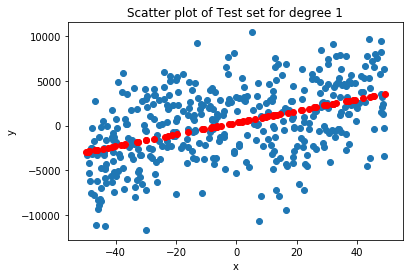

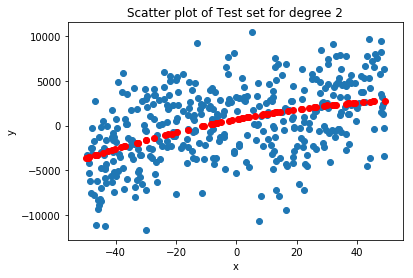

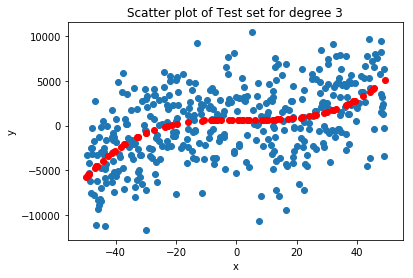

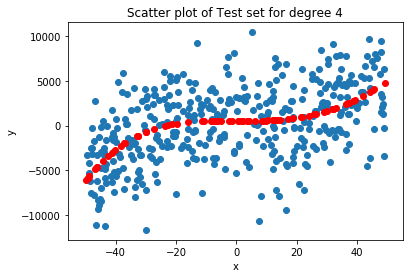

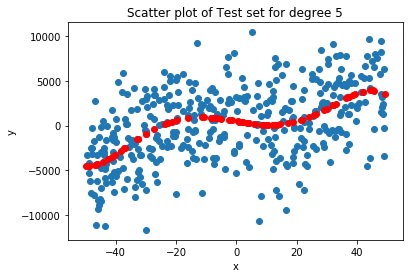

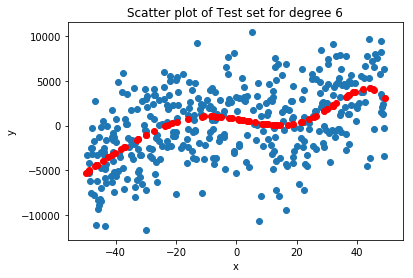

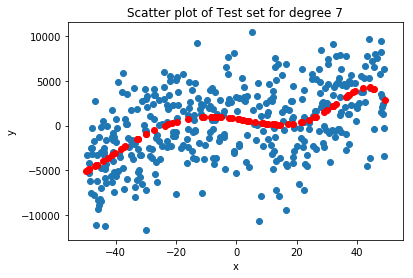

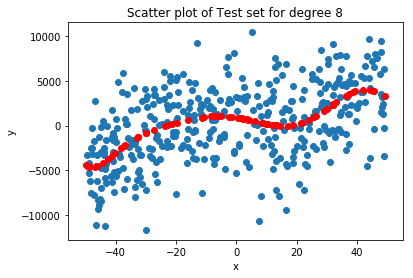

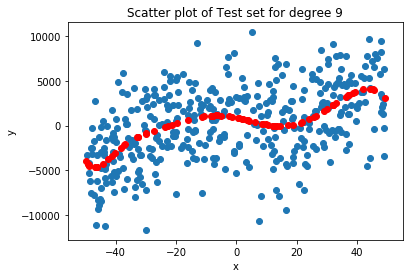

In [19]:
for i in range(1, 10):
    plt.scatter(X_train[0, :], Y_train[0, :])
    plt.scatter(x_test[:,0], degree_hypo_list[i-1], color='red')
    plt.title('Scatter plot of Test set for degree {}'.format(i))

    plt.xlabel('x')
    plt.ylabel('y')

    plt.show()

Here the red line is a representation of the performance of the model for each degree of polynomial when represented with the training data. This form of representation makes it easier for us to see how adding additional polynomial features in the form of x^i makes our hypothesis function more and more accurate. 

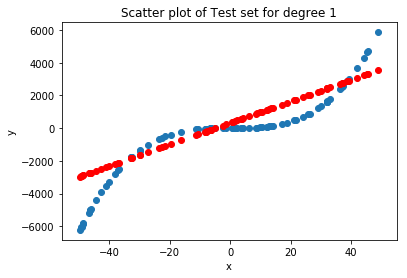

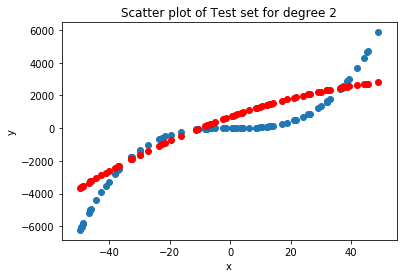

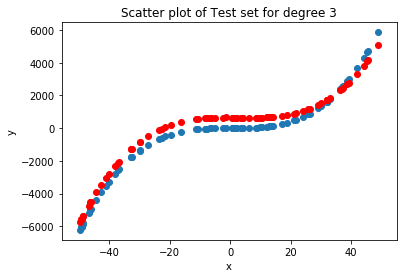

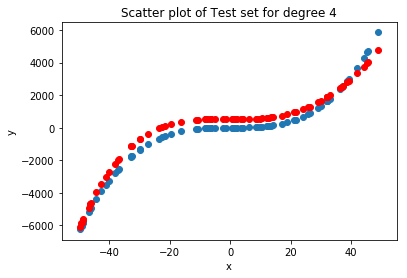

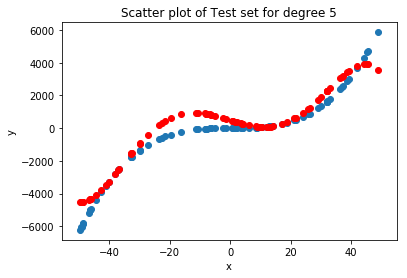

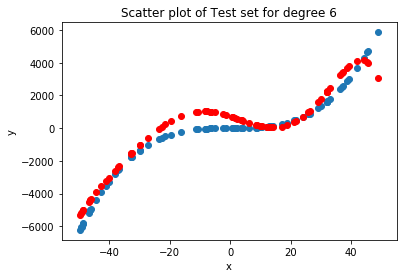

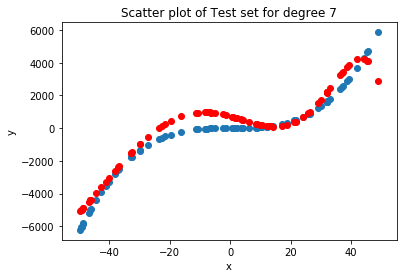

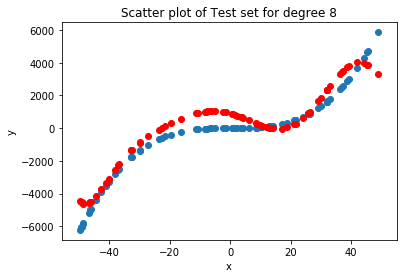

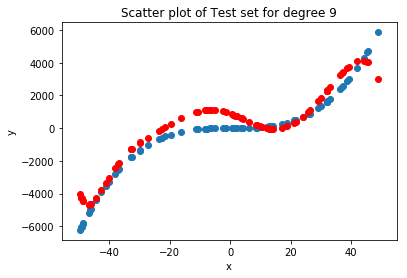

In [20]:
for i in range(1, 10):
    plt.scatter(x_test[:, 0], Y_test[:, 0])
    plt.scatter(x_test[:,0], degree_hypo_list[i-1], color='red')
    plt.title('Scatter plot of Test set for degree {}'.format(i))

    plt.xlabel('x')
    plt.ylabel('y')

    plt.show()

The above graph is a representation of the test data, along with the predicted plot of the test data via the hypothesis function. Once again, we can see the accuracy of our model using these graphs. As seen from the total error graph, the degree 3 model seems to perform the best on average.